# Predicting Credit Default Risk to Reduce Financial Losses

## Business Problem
Financial institutions face losses when customers fail to meet their credit obligations.  
The objective of this project is to predict whether a credit card client will default on their payment in the following month, enabling lenders to reduce expected losses, improve risk-based pricing, and intervene early with high-risk customers.

## Stakeholders
Primary: 
* Credit risk and risk analytics teams

Secondary:
* Product managers responsible for pricing and credit limits
* Collections teams prioritising outreach
* Senior management monitoring portfolio risk

## Objective
Build and evaluate classification models that predict the probability of default next month using borrower demographics and credit behaviour data. ------------------------------Predict default (1) vs non-default (0) using borrower and credit characteristics, and evaluate models with metrics that prioritise catching defaulters.

## Variables
y = default.payment.next.month

X = all borrower/credit variables excluding the target (drop ID)


# Load libraries and data

In [9]:
!pip install kagglehub

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import os

# Download dataset from Kaggle / UCI
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")

# print("Path to dataset files:", path)

os.listdir(path)

df = pd.read_csv(os.path.join(path, "UCI_Credit_Card.csv"))
df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## Exploratory Data Analysis (EDA)

### Goal: understand the target variable deeper


In [3]:
# Size and structure of data
df.shape


(30000, 25)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [36]:
df.isnull().sum()


ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [ ]:
"""
The dataset contains no missing values or duplicate values. All variables are numeric, which simplifies preprocessing
"""

### 1. Unique values of target variable (default  status)

In [8]:
# Check the unique values in the target variable
df['default.payment.next.month'].unique()


array([1, 0], dtype=int64)

In [9]:
# Count observations in each class --how many defaults vs non-defaults
df['default.payment.next.month'].value_counts()


0    23364
1     6636
Name: default.payment.next.month, dtype: int64

In [ ]:
"""
The dataset contains approximately 30,000 observations and 25 variables, including the target variable.  
The target variable is binary, with about 22% of borrowers defaulting in the following month and 78% not defaulting.
DEf:
1=default
0=no default
This indicates a moderately imbalanced dataset, making accuracy a potentially misleading evaluation metric. Therefore, this project will  prioritize evaluation metrics such as recall for the default class and ROC-AUC to better capture the model’s ability to identify high-risk borrowers.
"""

### 2. Credit limit (LIMIT_BAL) by default status

In [10]:
# Compare credit limit by default status
df.groupby('default.payment.next.month')['LIMIT_BAL'].describe()


,count,mean,std,min,25%,50%,75%,max
default.payment.next.month,,,,,,,,
0,23364.0,178099.726074,131628.359660,10000.0,70000.0,150000.0,250000.0,1000000.0
1,6636.0,130109.656420,115378.540571,10000.0,50000.0,90000.0,200000.0,740000.0


In [ ]:
"""
Borrowers who default tend to have lower credit limits than those who do not default. Both the mean (≈130k vs ≈178k) and median (90k vs 150k) credit limits are lower for defaulters, suggesting that lower credit capacity is associated with higher default risk in this dataset
"""

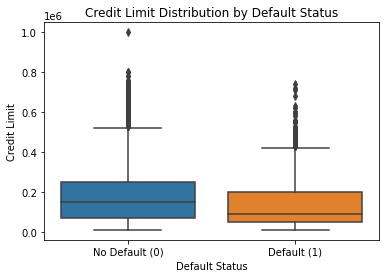

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    x='default.payment.next.month',
    y='LIMIT_BAL',
    data=df
)

plt.xticks([0, 1], ['No Default (0)', 'Default (1)'])
plt.xlabel('Default Status')
plt.ylabel('Credit Limit')
plt.title('Credit Limit Distribution by Default Status')

plt.show()



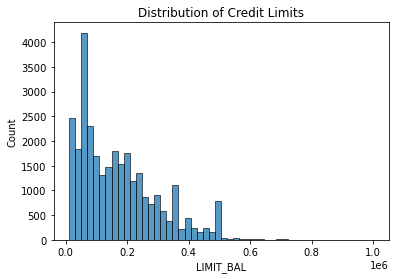

In [ ]:
sns.histplot(df['LIMIT_BAL'], bins=50)
plt.title('Distribution of Credit Limits')
plt.show()

"""
right-skewed credit limits
many low-limit cards, few high-limit ones
"""


In [ ]:
"""
The boxplot compares credit limits between borrowers who defaulted and those who did not, where 0 represents non-default and 1 represents default.
The entire distribution of credit limits for defaulters is shifted downward compared to non-defaulters.
The boxplot confirms that borrowers who default generally have lower credit limits than those who do not. While there is some overlap between the two groups, the median and interquartile range for defaulters are consistently lower, indicating that credit limit is a useful predictor of default risk.
"""

### 3. Repayment Status vs Default class

In [14]:
df.groupby('default.payment.next.month')['PAY_0'].describe()


,count,mean,std,min,25%,50%,75%,max
default.payment.next.month,,,,,,,,
0,23364.0,-0.211222,0.952464,-2.0,-1.0,0.0,0.0,8.0
1,6636.0,0.668174,1.383252,-2.0,0.0,1.0,2.0,8.0


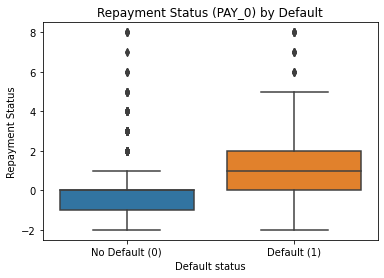

In [16]:
sns.boxplot(
    x='default.payment.next.month',
    y='PAY_0',
    data=df
)
plt.xticks([0, 1], ['No Default (0)', 'Default (1)'])
plt.title('Repayment Status (PAY_0) by Default')
plt.xlabel('Default status')
plt.ylabel('Repayment Status')
plt.show()


In [ ]:
"""
The boxplot shows a clear difference in repayment behavior between borrowers who default and those who do not. Non-defaulters are concentrated around on-time or early repayments, while defaulters exhibit higher repayment delays, reflected in a higher median and wider spread of PAY_0 values. This confirms that recent repayment status is a strong predictor of default risk.

"""

### 4. Bill amounts (debt burden) vs default status
#### Bill amounts capture outstanding debt. Even with the same credit limit, higher unpaid balances can increase default risk.

In [17]:
df.groupby('default.payment.next.month')['BILL_AMT1'].describe()


,count,mean,std,min,25%,50%,75%,max
default.payment.next.month,,,,,,,,
0,23364.0,51994.227273,73577.606694,-165580.0,3677.25,23119.5,69027.0,964511.0
1,6636.0,48509.162297,73782.067220,-6676.0,2987.75,20185.0,59626.5,613860.0


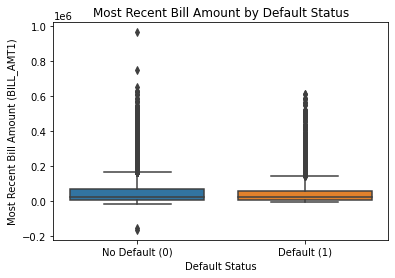

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    x='default.payment.next.month',
    y='BILL_AMT1',
    data=df
)

plt.xticks([0, 1], ['No Default (0)', 'Default (1)'])
plt.xlabel('Default Status')
plt.ylabel('Most Recent Bill Amount (BILL_AMT1)')
plt.title('Most Recent Bill Amount by Default Status')

plt.show()


In [ ]:
"""
The average and median bill amounts for defaulters and non-defaulters are relatively close.
Both groups show high variability and a large number of outliers, indicating wide differences in outstanding balances.
The boxplot shows substantial overlap between defaulters and non-defaulters, with no strong shift in the distribution similar to what we observed for repayment status.
Although non-defaulters have slightly higher upper-range values, the overall separation between the two groups is weak.

The summary statistics and boxplot indicate that bill amounts alone do not strongly distinguish defaulters from non-defaulters. While both groups exhibit wide variation and extreme outliers in outstanding balances, their median and interquartile ranges are largely overlapping. This suggests that bill amount, by itself, is a weaker predictor of default risk compared to recent repayment behavior, though it may still provide complementary information when combined with other features in the model.

"""

### 5. Age vs default status

In [19]:
df.groupby('default.payment.next.month')['AGE'].describe()


,count,mean,std,min,25%,50%,75%,max
default.payment.next.month,,,,,,,,
0,23364.0,35.417266,9.077355,21.0,28.0,34.0,41.0,79.0
1,6636.0,35.725738,9.693438,21.0,28.0,34.0,42.0,75.0


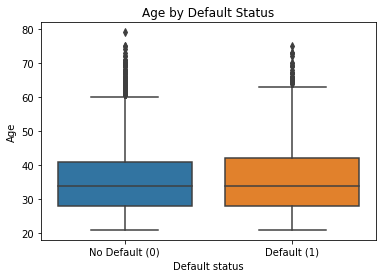

In [21]:
sns.boxplot(
    x='default.payment.next.month',
    y='AGE',
    data=df
)
plt.xticks([0, 1], ['No Default (0)', 'Default (1)'])
plt.title('Age by Default Status')
plt.xlabel('Default status')
plt.ylabel('Age')
plt.show()


In [ ]:
"""
The age distribution for defaulters and non-defaulters is broadly similar, with substantial overlap in both the median and interquartile range. Defaulters tend to be slightly younger on average, but the difference is modest. This suggests that age alone is not a strong predictor of default risk, though it may contribute marginally when combined with financial and repayment features.

"""

### 6. Gender vs default status

In [26]:
pd.crosstab(df['SEX'], df['default.payment.next.month'], normalize='index') * 100


default.payment.next.month,0,1
SEX,,
1,75.832773,24.167227
2,79.223719,20.776281


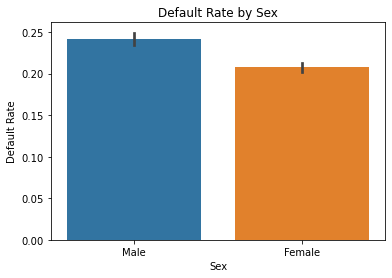

In [ ]:
sns.barplot(
    x='SEX',
    y='default.payment.next.month',
    data=df
)

plt.title('Default Rate by Sex')
plt.xlabel('Sex')
plt.ylabel('Default Rate')
plt.xticks([0, 1], ['Male', 'Female'])
plt.show()


In [ ]:
"""
The default rates for male and female borrowers are relatively similar, with only a small difference between the two groups. This indicates that sex is not a primary driver of default risk in this dataset, though it may still provide limited additional information when used alongside financial and repayment variables.
"""

### 7. Default status by education

In [29]:
pd.crosstab(
    df['EDUCATION'],
    df['default.payment.next.month'],
    normalize='index'
) * 100


default.payment.next.month,0,1
EDUCATION,,
0,100.000000,0.000000
1,80.765234,19.234766
2,76.265146,23.734854
3,74.842384,25.157616
4,94.308943,5.691057
5,93.571429,6.428571
6,84.313725,15.686275


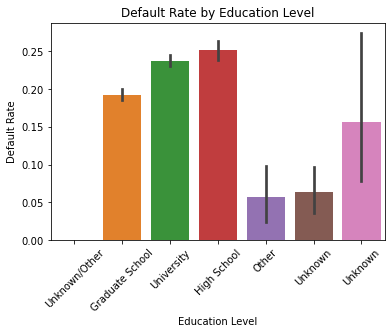

In [30]:
sns.barplot(
    x='EDUCATION',
    y='default.payment.next.month',
    data=df
)

plt.title('Default Rate by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Default Rate')
plt.xticks(
    ticks=[0, 1, 2, 3, 4, 5, 6],
    labels=[
        'Unknown/Other',
        'Graduate School',
        'University',
        'High School',
        'Other',
        'Unknown',
        'Unknown'
    ],
    rotation=45
)
plt.show()


In [ ]:
"""
Default rates vary modestly across education levels, with borrowers having lower formal education showing slightly higher default rates. However, the differences are not large, suggesting that education is a secondary predictor compared to repayment history and credit capacity.

"""

In [ ]:
### 8. Default status by marriage

In [31]:
pd.crosstab(
    df['MARRIAGE'],
    df['default.payment.next.month'],
    normalize='index'
) * 100


default.payment.next.month,0,1
MARRIAGE,,
0,90.740741,9.259259
1,76.528296,23.471704
2,79.071661,20.928339
3,73.993808,26.006192


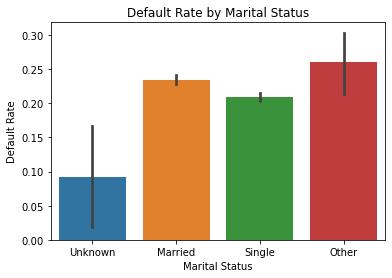

In [32]:
sns.barplot(
    x='MARRIAGE',
    y='default.payment.next.month',
    data=df
)

plt.title('Default Rate by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Default Rate')
plt.xticks(
    ticks=[0, 1, 2, 3],
    labels=['Unknown', 'Married', 'Single', 'Other']
)
plt.show()


In [ ]:
"""
Default rates differ slightly by marital status, with single borrowers exhibiting marginally higher default rates. Overall, marital status does not strongly separate defaulters from non-defaulters and is likely to play a supporting role in the predictive model.

"""

In [ ]:
## Wrapping up of EDA
""""
Exploratory data analysis on a few x variables against target variable reveals clear differences between borrowers who defaulted and those who did not. Default behavior is moderately imbalanced, with approximately 22% of borrowers defaulting in the following month. Credit capacity, measured by credit limit, shows a strong relationship with default, as defaulters tend to have lower credit limits. Recent repayment behavior is the strongest indicator of default risk, with defaulters exhibiting significantly worse repayment status compared to non-defaulters.
In contrast, bill amounts show substantial overlap between the two groups, suggesting that outstanding balances alone are a weaker predictor of default. Demographic variables such as age, sex, education, and marital status display only modest differences between defaulters and non-defaulters, indicating that they are likely to play a supporting rather than primary role in prediction. Overall, the analysis suggests that repayment history and credit capacity are the most informative features for modeling default risk.

""""
#for slides
""""
Exploratory analysis shows that repayment behavior and credit limits are the strongest indicators of default risk. Defaulters tend to have worse recent repayment status and lower credit limits, while demographic factors such as age, sex, education, and marital status show only modest differences. These insights motivate a predictive modeling approach that prioritizes behavioral and financial variables.
""""

## Model development

We first define the target variable and independent variables 
* The target variable represents whether a borrower defaults in the following month. 
* The independent set includes borrower demographics, credit capacity, repayment history, and billing information etc
* Identifier variables that do not contain predictive information are removed.


In [ ]:
# Define target variable and independent variables
# Define target variable
y = df['default.payment.next.month']
X = df.drop(columns=['ID', 'default.payment.next.month'])

In [ ]:
X.shape, y.shape

# This confirms that the predictors matrix (X) contains 23 independent variables and the target vector (y) contains the binary default outcome for all 30,000 observations.


((30000, 23), (30000,))

In [39]:
# Train test split
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 80% train, 20% test
    random_state=42,    # reproducibility
    stratify=y          # keeps same default rate in train and test
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((24000, 23), (6000, 23), (24000,), (6000,))